In [1]:
import numpy as np

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.utils import R_trendfilter
from mrashpen.inference.mrash_wrapR import MrASHR
from mrashpen.models.mixture_gaussian import emfit

from gradvi.inference import LinearRegression, Trendfiltering
from gradvi.normal_means import NormalMeans, NormalMeansFromPosterior
from gradvi.tests import toy_priors, toy_data
from gradvi.optimize import moving_average as gvma
from gradvi.models import basis_matrix as gvbm
from gradvi.models import TrendfilteringModel

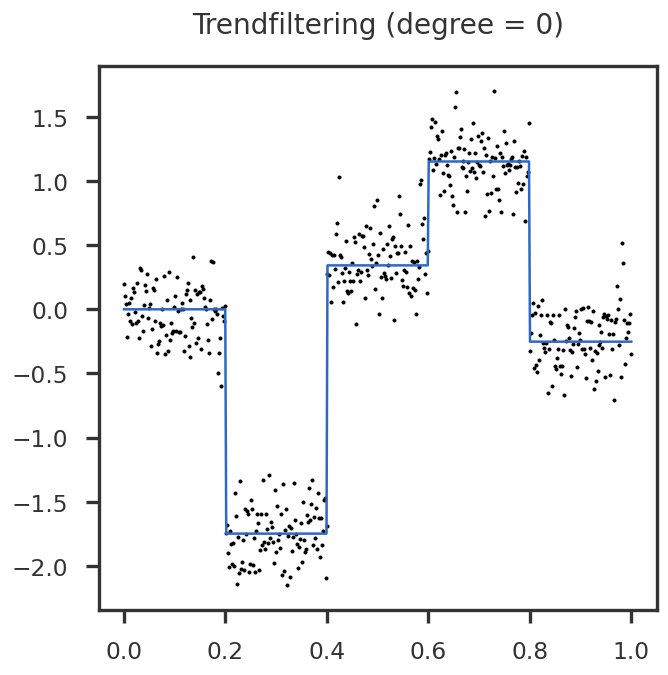

In [98]:
n = 512
x = np.linspace(0, 1, n)
np.random.seed(100)

degree = 0
nknots = 4
strue  = 0.2
knots  = np.linspace(0, 1, nknots+2)[1:-1]

data = toy_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                        signal = "normal", seed = 100,
                        include_intercept = False)

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)
fig = plt.figure(figsize = (6, 6))

ax = fig.add_subplot(1, 1, 1)
ax.scatter(data.x, data.y, s = 2, color = 'black')
ax.plot(data.x, data.ytrue)
ax.set_title(f"Trendfiltering (degree = {degree})", pad = 20)

plt.show()

In [99]:
s2_true = np.var(data.y - data.ytrue)

H = gvbm.trendfiltering(n, degree)
Hinv = gvbm.trendfiltering_inverse(n, degree)

prior = toy_priors.get_ash(k = 20, sparsity = 0.9, skbase = 2.0, skfactor = 1.0)
wtrue = emfit(np.dot(Hinv, data.ytrue), prior.sk)
prior.update_w(wtrue)

In [100]:
'''
Get oracle ELBO from mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(H, data.y, prior.sk,
            binit = np.dot(Hinv, data.ytrue), winit = wtrue, s2init = s2_true,
            update_pi = False, update_sigma2 = False)

mrash_ypred = np.dot(H, mrash_r.coef) + mrash_r.intercept
oracle_elbo = mrash_r.elbo_path[-1]

Mr.ASH terminated at iteration 16.


In [101]:
tf_y, tf_fit = R_trendfilter.fit(data.y, order = degree)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



### Optimize coefficients only

In [102]:
data.Hinv

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

In [103]:
data.H

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [104]:
Omega = s2_true * np.dot(Hinv, Hinv.T)
X = np.sqrt(np.linalg.inv(Omega))

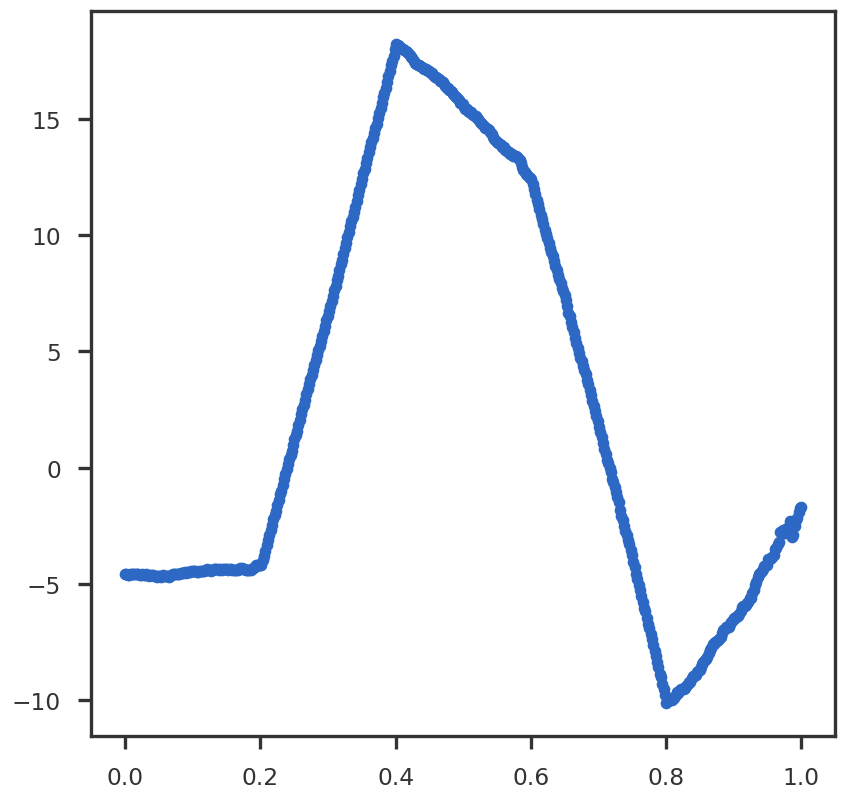

In [105]:
z = np.dot(Hinv, data.y)
b_init = np.dot(data.Hinv, data.ytrue)
z_tilde = np.dot(X, z)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(data.x, z_tilde)
#ax1.scatter(z, b_init)
#mpl_utils.plot_diag(ax1)
plt.show()

In [120]:
gvlin = LinearRegression(obj = 'reparametrize', optimize_s = False, optimize_w = True, fit_intercept = False,
                         debug = False, display_progress = False, maxiter=10000)
gvlin.fit(X, z_tilde, prior, b_init = np.dot(data.Hinv, tf_y), s2_init = 1.0)

In [121]:
gvlin.niter

619

In [122]:
ypred = np.dot(H, gvlin.coef)
bhat = np.dot(Hinv, ypred)

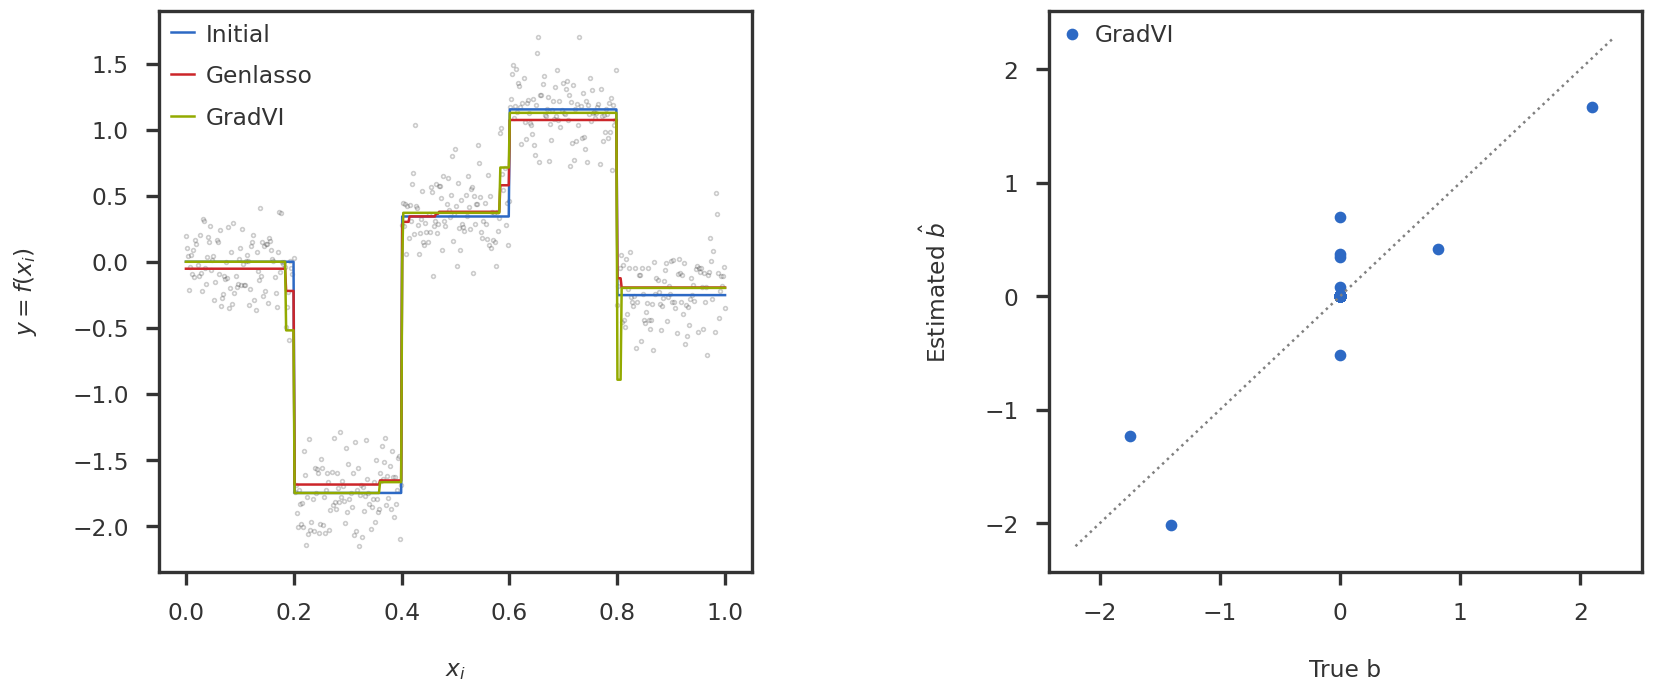

In [123]:
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(x, data.y, s = 5, edgecolor = 'black', facecolor='white', alpha = 0.2)
#ax1.plot(x, data.ytrue, label = "True")
ax1.plot(x, np.dot(H, b_init), label = "Initial")
ax1.plot(x, tf_y, label = "Genlasso")
ax1.plot(data.x, np.dot(H, bhat), label = "GradVI")
#ax1.scatter(data.x, np.dot(X, gvlin.coef))
#ax1.scatter(data.x, z_tilde)
ax1.legend()
ax1.set_xlabel(r"$x_i$")
ax1.set_ylabel(r"$y = f(x_i)$")


ax2.scatter(data.btrue, bhat, label = "GradVI")

ax2.set_xlabel("True b")
ax2.set_ylabel(r"Estimated $\hat{b}$")
ax2.legend()

mpl_utils.plot_diag(ax2)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.5)
plt.show()

In [110]:
np.where(data.btrue != 0)

(array([103, 205, 307, 409]),)

In [111]:
np.where(np.abs(bhat) > 0.005)

(array([103, 205, 307, 409]),)

In [ ]:
# '''
# GradVI Trendfiltering
# '''
# def fun1(params, y, A, prior, sj2, s2, dj, jac = True):
#     n = y.shape[0]
#     k = prior.k
#     x = params[:n]
#     a = params[n:]
#     prior.update_wmod(a)
    
#     r = y - x
#     rTr = np.dot(r, r)
    
#     #sj2 = s2 / dj
#     b = np.dot(A, x)
#     nm = NormalMeansFromPosterior(b, prior, sj2, scale = s2, d = dj, method = 'newton')
#     Pb, dPdb, dPdw, dPds2 = nm.penalty_operator(jac = True)
    
#     h = (0.5 * rTr / s2) + np.sum(Pb)
#     #h = np.sum(Pb)
#     if jac:
#         dhdx = - r / s2 + np.dot(A.T, dPdb)
#         #dhdx = np.dot(A.T, dPdb)
#         dhdw  = np.sum(dPdw, axis = 0)
#         dhda  = prior.wmod_grad(dhdw)
#         return h, np.concatenate((dhdx, dhda))
#     return h